In [177]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint

path = 'C://Users//richard//OneDrive//Documents//Audacity//wavfiles//'
audio_classes_path = 'C://Users//richard//OneDrive//Documents//Audacity//audio_classes.csv'

## Method
- Using the csv file which contains the list of files and their labels, generate a pandas dataframe.
- Use the dataframe to index the files and get a random window of audio
- Train on this audio using a CNN.  Train, test split is not required as all the audio comes from the same place and is of small size
- Go through all the files every 0.1 s and compare prediction to label 
- See Final preedcitons and conclusions at bottom of file.

## Class distribution

C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


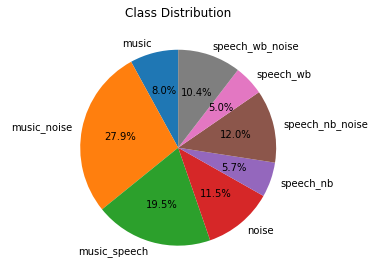

In [178]:
df = pd.read_csv(audio_classes_path)
df.set_index('file_name', inplace=True)

for f in df.index:
    rate, signal = wavfile.read(path+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [179]:
df.head()

,label,length
file_name,,
music_plus_noise1.wav,music_noise,7.543288
music_plus_noise2.wav,music_noise,6.991315
music_twintones1.wav,music_noise,5.944308
music_plus_speech1.wav,music_speech,4.768209
music1.wav,music,2.018050


In [180]:
#get number of samples to draw from the audio files
n_samples = 2 * int(df['length'].sum()/0.1)
n_samples

1896

In [181]:
#total length of all the audio in the files
df.length.sum()

94.87106575963719

In [182]:
#0 -1 class dist
prob_dist = class_dist / class_dist.sum()

#get a choice of instrument randomly based on class distribution
choices = np.random.choice(class_dist.index,p=prob_dist)

class_dist=class_dist.sort_values(ascending=False)
class_dist

label
music_noise        6.826304
music_speech       4.768209
speech_nb_noise    2.947545
noise              2.823212
speech_wb_noise    2.554422
music              1.955057
speech_nb          1.409063
speech_wb          1.223050
Name: length, dtype: float64

In [183]:
class_dist.index

Index(['music_noise', 'music_speech', 'speech_nb_noise', 'noise',
       'speech_wb_noise', 'music', 'speech_nb', 'speech_wb'],
      dtype='object', name='label')

## Make a CNN model
Use general image processing network, increasing size of feature maps at each layer.  As output is eight classes use softmax at output to get majority class probability.  Max pooling can be used but images are small anyway 13x13 or 26x26.  Since using small size and same data files will overfit anyway so not using test and validation set.

In [184]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    #model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    #model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    #model.add(MaxPool2D((2,2)))
    model.add(Conv2D(256,(3,3),activation='relu',strides=(1,1),padding='same'))
    #model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(8,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

## Make a helper class

In [185]:
class Config():
    def __init__(self,mode = 'conv', nfilt=26, nfeat=26, nfft=2048,rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

## Generate data from files
Need to get random chunks of the data from the files.  These chunks here are 0.1s long and selected randomly from the distribution given above


In [186]:
#generate random sampling from dataset
def build_rand_feat():
    X = [];y=[]
    
    _min,_max = float('inf'),-float('inf')
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)   
        
        #get random file based on random instrument
        file = np.random.choice(df[df.label==rand_class].index)      
        rate,wav = wavfile.read(path + file)                        
        label = df.at[file,'label'] 
        
        #get random chunk from file
        rand_index = np.random.randint(0,wav.shape[0] - config.step) 
        sample = wav[rand_index:rand_index+config.step]              
        X_sample = mfcc(sample,rate,numcep=config.nfeat, nfilt = config.nfilt, nfft=config.nfft)
        
        #running update of min/max
        _min = min(np.amin(X_sample),_min)                        
        _max = max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))                             #get index number
        
    config.min = _min
    config.max = _max
    
    X, y = np.array(X),np.array(y)                                #normalise the data
    
    X = (X - _min)/ (_max - _min)
        
    X = X.reshape(X.shape[0],X.shape[1], X.shape[2],1) #samples * rows (time) * cols(mfccs) * 1 
    y = to_categorical(y,num_classes=8)
    
    _min = str(_min)
    _max = str(_max)
    
    return X,y,_min,_max

In [187]:
config= Config()

In [188]:
#build dataset using distirbution we have defined
X,y,_min,_max = build_rand_feat()
y_flat = np.argmax(y,axis=1)      #get the max value across each row 
input_shape = (X.shape[1],X.shape[2],1)
model = get_conv_model()

  3%|██▌                                                                            | 63/1896 [00:00<00:06, 304.35it/s]C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1896/1896 [00:05<00:00, 317.53it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 3, 26, 32)         320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 3, 26, 64)         18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 26, 128)        73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 26, 256)        295168    
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 26, 256)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 19968)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               5112064   
__________

In [189]:
print(X.shape) 
print(y.shape)

(1896, 3, 26, 1)
(1896, 8)


In [190]:
#base weights on prob dist defined above - need as unbalanced
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)  

In [191]:
class_weight

array([1.05803571, 1.52903226, 0.43807763, 1.15048544, 2.69318182,
       0.62204724, 1.16748768, 2.41836735])

In [192]:
#try adding weights to classes or not
#model.fit(X,y,epochs=30,batch_size=32,shuffle=True,class_weight=class_weight,verbose=2)
model.fit(X,y,epochs=50,batch_size=16,shuffle=True,verbose=2)

Epoch 1/50
 - 2s - loss: 1.8995 - acc: 0.2911
Epoch 2/50
 - 2s - loss: 0.7511 - acc: 0.7431
Epoch 3/50
 - 2s - loss: 0.5452 - acc: 0.8043
Epoch 4/50
 - 2s - loss: 0.4738 - acc: 0.8233
Epoch 5/50
 - 2s - loss: 0.3807 - acc: 0.8523
Epoch 6/50
 - 2s - loss: 0.3445 - acc: 0.8745
Epoch 7/50
 - 2s - loss: 0.3194 - acc: 0.8739
Epoch 8/50
 - 2s - loss: 0.3054 - acc: 0.8797
Epoch 9/50
 - 2s - loss: 0.2588 - acc: 0.9024
Epoch 10/50
 - 2s - loss: 0.2461 - acc: 0.9103
Epoch 11/50
 - 2s - loss: 0.2229 - acc: 0.9182
Epoch 12/50
 - 2s - loss: 0.2072 - acc: 0.9272
Epoch 13/50
 - 2s - loss: 0.2244 - acc: 0.9204
Epoch 14/50
 - 2s - loss: 0.1882 - acc: 0.9330
Epoch 15/50
 - 2s - loss: 0.1687 - acc: 0.9346
Epoch 16/50
 - 2s - loss: 0.1273 - acc: 0.9525
Epoch 17/50
 - 2s - loss: 0.1390 - acc: 0.9499
Epoch 18/50
 - 2s - loss: 0.1422 - acc: 0.9509
Epoch 19/50
 - 2s - loss: 0.1192 - acc: 0.9578
Epoch 20/50
 - 2s - loss: 0.1400 - acc: 0.9515
Epoch 21/50
 - 2s - loss: 0.1037 - acc: 0.9641
Epoch 22/50
 - 2s - lo

# Predictions 1
Use the model to get predictions, first across all files in directory

In [193]:
def build_pred_all_files(fn2class,audio_dir=path):
    y_true = []
    y_pred = []
    fn_prob = {}
        
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir,fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []
        y_per_file=[]
        
        #print(wav.shape[0],config.step,fn)
        #break

        for i in range(0,wav.shape[0]-config.step,config.step):
            sample = wav[i:i+config.step]
            #sample is a block of samples x secs (0.1) long
            x = mfcc(sample,rate, numcep=config.nfeat,nfilt = config.nfilt,nfft=config.nfft)
            x = (x-float(_min))/(float(_max)-float(_min))
            x = x.reshape(1,x.shape[0],x.shape[1],1)
            
            #for every block of samples get the mfcc and compare to target
            #y_hat is probability for each class - softmax in final layer
            y_hat = model.predict(x)
            y_prob.append(y_hat)
            #y_pred is class corrsponding to max prob. for each block of samples (every x secs)
            y_pred.append(np.argmax(y_hat))
            #y_true is the real class
            y_true.append(c)
            
        #print(label,c)
        fn_prob[fn] = np.mean(y_prob,axis=0).flatten()
        
    return y_true, y_pred, fn_prob    

In [194]:
#y_pred is the result for each block of samples for every file
#y_true is the actual value for each block of samples for every file
#fn_prob is the value for each class probabilty for each file, the max value indicates the most likely class

df = pd.read_csv(audio_classes_path)

classes = list(np.unique(df.label))

fn2class = dict(zip(df.file_name,df.label))

y_true, y_pred, fn_prob = build_pred_all_files(fn2class,path)
result = accuracy_score(y_true,y_pred)

 22%|█████████████████▉                                                                 | 8/37 [00:03<00:13,  2.13it/s]C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
 84%|████████████████████████████████████████████████████████████████████▋             | 31/37 [00:09<00:01,  3.11it/s]C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:11<00:00,  3.12it/s]


In [195]:
#go through every file point x seconds and get total accuracy overall
print("The overall accuracy every 0.1 secs across all wav files is {:.2f}".format(result))

The overall accuracy every 0.1 secs across all wav files is 0.82


## Prediction 2 
Label each file using the majority class per all 0.1 seconds per file.  Fo example is music1.wav labelled as music?  

In [205]:
#write result for each file usually 100% correct?
if write_to_output:
    y_probs = []
    for i, row in df.iterrows():
        y_prob = fn_prob[row.file_name]
        y_probs.append(y_prob)
        for c,p in zip(classes,y_prob):
            df.at[i,c] = p
    y_pred = [ classes [ np.argmax(y)] for y in y_probs] 
    df['y_pred'] = y_pred
    #get rid of the probabilities for write to file
    df = df[["file_name", "label",'y_pred']]
    #df.to_csv('predictions.csv',index=False)
df

,file_name,label,y_pred
0,music_plus_noise1.wav,music_noise,music_noise
1,music_plus_noise2.wav,music_noise,music_noise
2,music_twintones1.wav,music_noise,music_noise
3,music_plus_speech1.wav,music_speech,music_speech
4,music1.wav,music,music
5,music2.wav,music,music
6,music3.wav,music,music
7,music4.wav,music,music
8,music5.wav,music,music
9,noise1.wav,noise,noise


All files are correctly labelled as the correct type.  Doesn't agree with results below!

# Final Predictions
Get the predictions for every x samples and compare for each file. These are the final and most appropiate results

In [197]:
def build_pred_per_file(fn2class,audio_dir,fn):
    y_true = []
    y_pred = []
        
    #for fn in tqdm(os.listdir(audio_dir)):
    rate, wav = wavfile.read(os.path.join(audio_dir,fn))
    label = fn2class[fn]
    c = classes.index(label)

    for i in range(0,wav.shape[0]-config.step,config.step):
        sample = wav[i:i+config.step]
        #sample is a block of samples x secs long
        x = mfcc(sample,rate, numcep=config.nfeat,nfilt = config.nfilt,nfft=config.nfft)
        x = (x-float(_min))/(float(_max)-float(_min))
        x = x.reshape(1,x.shape[0],x.shape[1],1)
        #for every block of samples get the mfcc and compare to target
        #y_hat is probability for each class - softmax in final layer
        y_hat = model.predict(x)
        #y_pred is class corrsponding to max prob. for each block of samples (every x secs)
        y_pred.append(np.argmax(y_hat))
        #y_true is the real class
        y_true.append(c)

    return y_true, y_pred

In [198]:
files = os.listdir(path)
sum_scores = 0
for file in files:
    y_true, y_pred = build_pred_per_file(fn2class,path,file)
    score = accuracy_score(y_true,y_pred)
    sum_scores += score;
    print("The overall accuracy score per 0.1 secs is {:.2f} for {}".format(score,file))

print(sum_scores/len(files))

The overall accuracy score per 0.1 secs is 0.78 for music1.wav
The overall accuracy score per 0.1 secs is 1.00 for music2.wav
The overall accuracy score per 0.1 secs is 0.93 for music3.wav
The overall accuracy score per 0.1 secs is 0.98 for music4.wav
The overall accuracy score per 0.1 secs is 0.67 for music5.wav
The overall accuracy score per 0.1 secs is 0.92 for music_plus_noise1.wav
The overall accuracy score per 0.1 secs is 0.56 for music_plus_noise2.wav
The overall accuracy score per 0.1 secs is 0.98 for music_plus_speech1.wav


C:\Users\richard\Anaconda3\envs\tf15\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


The overall accuracy score per 0.1 secs is 0.87 for music_twintones1.wav
The overall accuracy score per 0.1 secs is 1.00 for noise1.wav
The overall accuracy score per 0.1 secs is 1.00 for noise2.wav
The overall accuracy score per 0.1 secs is 1.00 for noise3.wav
The overall accuracy score per 0.1 secs is 1.00 for noise4.wav
The overall accuracy score per 0.1 secs is 1.00 for noise5.wav
The overall accuracy score per 0.1 secs is 1.00 for noise6.wav
The overall accuracy score per 0.1 secs is 0.82 for speech_nb1.wav
The overall accuracy score per 0.1 secs is 0.87 for speech_nb2.wav
The overall accuracy score per 0.1 secs is 0.96 for speech_nb3.wav
The overall accuracy score per 0.1 secs is 0.75 for speech_nb4.wav
The overall accuracy score per 0.1 secs is 0.78 for speech_nb5.wav
The overall accuracy score per 0.1 secs is 0.83 for speech_nb6.wav
The overall accuracy score per 0.1 secs is 0.98 for speech_nb_plus_noise1.wav
The overall accuracy score per 0.1 secs is 0.99 for speech_nb_plus_no

# Conclusions
- We can see that the results for tend to be much better for single component audio than audio composed of two components.  For example noise and speech_wb_plus_noise.
- The cause of the error is the way the files were made by me and the sample window used to collect the audio
- When the files were made I mixed two components together to generate the audio file.  For example speech plus noise was constructed using speech and twin tone noise.  Therefore in that file speech is continuous but varies in amplitude but the twin tone lasts only for a short time.  When I take a ramdom sample of the audio file I may not be taking speech AND twin tone - It may be just speech or speech AND small component of twin tone. I believe this is the main cause of errors you see here.
- This is also seen when making predictions, two component audio results can sometimes be very good - it just depends if the sample collection is capturing the two audio components.
